## Paper implementation using GPyTorch

### Imports

In [1]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile as wav
from sklearn.metrics import mean_squared_error

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Audio preprocessing

Preparing the audio for use in audio inpainting.

In [2]:
# Retrieve the sample rate and data from the audio fragment
rate, data = wav.read('3-notes.wav')

# Convert stereo to mono
data = [x[0] for x in data]

# GPyTorch only supports tensors, as it is built on PyTorch
data = torch.as_tensor(data)

# 400 datapoints is what is used for the length of a note segment
# This corresponds to ca. 0.05s of audio
length = torch.linspace(0, 400 / rate, 400)

# The stable segments chosen for each note
first_note = data[6100:6500]
second_note = data[7800:8200]
third_note = data[10000:10400]

# The excised part of the segment is between datapoints 200 and 300
# The other data is used to train the model
train_x = torch.cat((length[:200], length[300:]))
train_y = torch.cat((first_note[:200], first_note[300:]))
test_x = length[200:300]
test_y = first_note[200:300]

### Creating the GP model

This is very similar to the code shown in the tutorial on simple GP regression by the authors of GPyTorch. Only the kernel module has been changed.

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Each of the individual kernels has also been decorated with a ScaleKernel
        # A scale of 1 would have no influence whatsoever, so they are added in case
        # this scale should be different to 1
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) * \
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel()) * \
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel()) * \
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

### Training loop

In the training loop we optimize the hyperparameters of the model, in this case using the Adam optimizer.

In [4]:
# The amount of iterations the optimizer goes through
training_iter = 150

# Setting the model and likelihood in training mode
model.train()
likelihood.train()

# Selection of optimizer, in this case Adam with a learning rate of 0.2
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)

# The exact marginal log likelihood is used to calculate the loss of the model
# when using the hyperparameters in each iteration
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# The training loop
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    
    # Usually more info is displayed here, but with the amount of hyperparameters
    # it would get very cluttered and confusing
    if (i + 1) % 10 is 0:
        print('Step %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()    

Step 10/150 - Loss: 206878.422
Step 20/150 - Loss: 6005.191
Step 30/150 - Loss: 233.712
Step 40/150 - Loss: 278.576
Step 50/150 - Loss: 234.413
Step 60/150 - Loss: 204.555
Step 70/150 - Loss: 175.541
Step 80/150 - Loss: 136.077
Step 90/150 - Loss: 120.457
Step 100/150 - Loss: 111.121
Step 110/150 - Loss: 102.810
Step 120/150 - Loss: 96.680
Step 130/150 - Loss: 92.493
Step 140/150 - Loss: 89.474
Step 150/150 - Loss: 87.084


In [9]:
# This prints out the raw values for each hyperparameter
# Using the constraints on them we can transform these values to their actual values (not done yet)
# Not very straight-forward when dealing with lots of hyperparameters
for param_name, param in model.named_parameters():
    print(f'{param_name:75} = {param.item()}')

likelihood.noise_covar.raw_noise                                            = 3.8587565422058105
mean_module.constant                                                        = -4.2184062004089355
covar_module.kernels.0.kernels.0.kernels.0.raw_outputscale                  = 6.070980072021484
covar_module.kernels.0.kernels.0.kernels.0.base_kernel.raw_lengthscale      = -4.484117031097412
covar_module.kernels.0.kernels.0.kernels.1.raw_outputscale                  = 6.071018695831299
covar_module.kernels.0.kernels.0.kernels.1.base_kernel.raw_period_length    = -5.7982306480407715
covar_module.kernels.0.kernels.1.raw_outputscale                            = 6.07100772857666
covar_module.kernels.0.kernels.1.base_kernel.raw_period_length              = -5.798229217529297
covar_module.kernels.1.raw_outputscale                                      = 6.07112455368042
covar_module.kernels.1.base_kernel.raw_lengthscale                          = -4.922402381896973
covar_module.kernels.1.base_kernel

### Predictions using the model

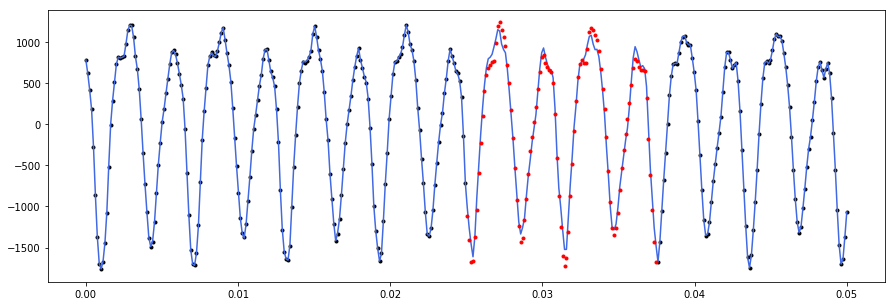

In [6]:
# Setting the model and likelihood in evaluation mode
model.eval()
likelihood.eval()

# Predicting the excised part of the note segment
# The prediction is on the whole segment of the note, 
# not just the excised part
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(length))
    
# Plotting the predictions
# Black dots represent training data
# Red dots represent missing values
# Blue line represents the prediction of the model
with torch.no_grad():
    plt.figure(figsize=(15,5))
    plt.plot(train_x.numpy(), train_y.numpy(), '.k')
    plt.plot(length.numpy(), predictions.mean.numpy(), 'royalblue')
    plt.plot(test_x.numpy(), test_y.numpy(), '.r')